### Data Wrangling

In [1]:
#load the necessary libraries
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')

In [2]:
users = pd.read_csv("takehome_users.csv",encoding = "ISO-8859-1")
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
users.columns

Index(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id'],
      dtype='object')

In [4]:
users.rename(columns = {'object_id':'user_id'},inplace = True)

In [5]:
users.dtypes

user_id                         int64
creation_time                  object
name                           object
email                          object
creation_source                object
last_session_creation_time    float64
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
org_id                          int64
invited_by_user_id            float64
dtype: object

In [6]:
users['creation_time'] = pd.to_datetime(users['creation_time'])
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'],unit='s')

In [7]:
engagement = pd.read_csv("takehome_user_engagement.csv",parse_dates =["time_stamp"])
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [8]:
engagement.dtypes

time_stamp    datetime64[ns]
user_id                int64
visited                int64
dtype: object

In [9]:
engagement.isna().any()

time_stamp    False
user_id       False
visited       False
dtype: bool

In [10]:
#checking weather the user has visited the product only one time on a given date or more than one time
assert(engagement.groupby(['user_id','time_stamp'])['visited'].count() == 1).all()

In [11]:
#checking for duplicate values
engagement.duplicated().any()

False

In [12]:
#getting the adopted users id list
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])
engagement['time_stamp'] = engagement['time_stamp'].dt.floor('d').astype(np.int64)
engagement = engagement.sort_values(['user_id', 'time_stamp']).drop_duplicates()

x = engagement.groupby('user_id')['time_stamp'].rolling(window=3)
y = pd.to_timedelta((x.max()- x.min())).dt.days
z = list(set(y[y <= 7].index.get_level_values('user_id')))
print(len(z))

1656


In [13]:
#creating the user adoption feature based on the list
users['user_adopted'] = [1 if x in z else 0 for x in users['user_id']]

In [14]:
users['user_adopted'].value_counts()

0    10344
1     1656
Name: user_adopted, dtype: int64

In [15]:
#user adoption percentage
print("{:.0%} of users are adopted".format(sum(users.user_adopted)/len(users.user_adopted)))

14% of users are adopted


In [16]:
#lets explore the users dataset in detail
users.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0


In [17]:
users.isna().any()

user_id                       False
creation_time                 False
name                          False
email                         False
creation_source               False
last_session_creation_time     True
opted_in_to_mailing_list      False
enabled_for_marketing_drip    False
org_id                        False
invited_by_user_id             True
user_adopted                  False
dtype: bool

Lets visualize the missingness to check missingness is by random chance or is there any coincidence between features for missingness.

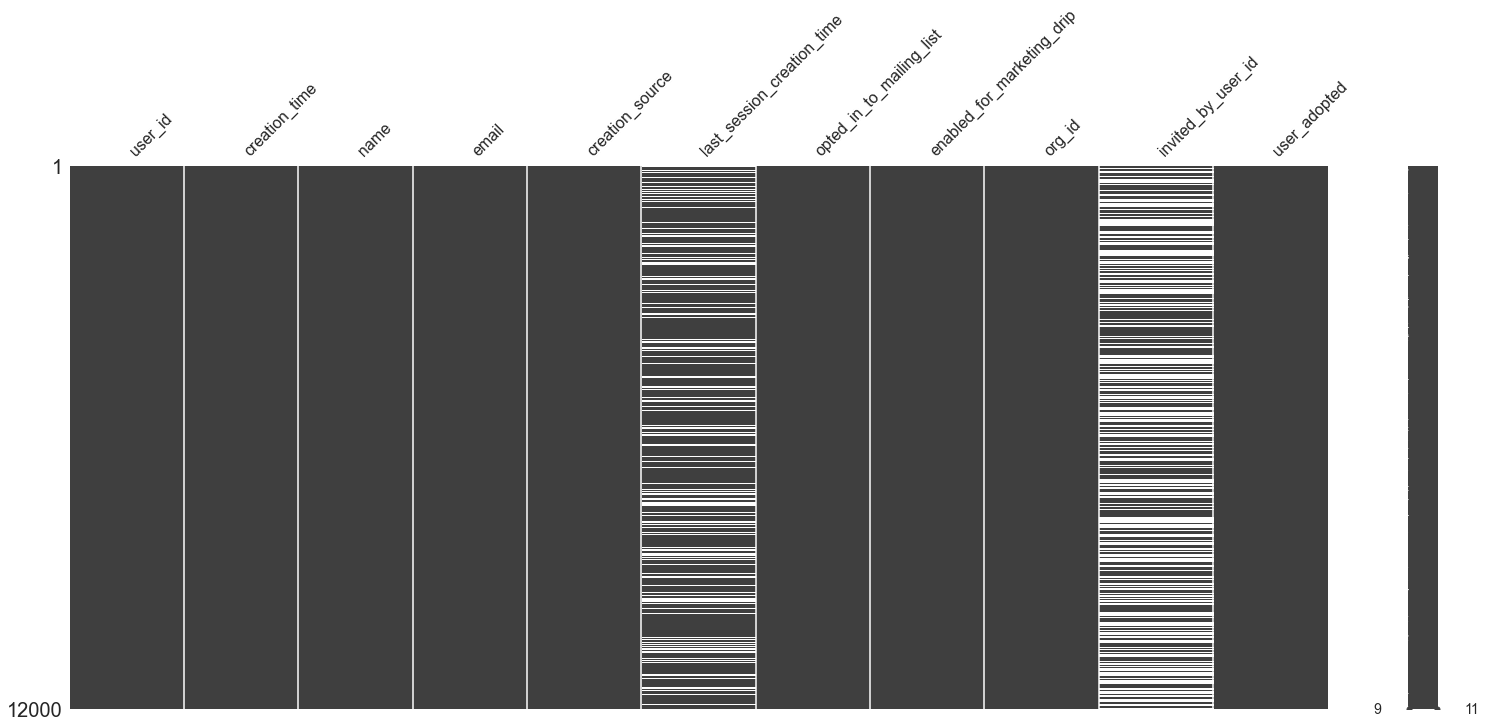

In [18]:
#visualizing missingness
import missingno as msno
msno.matrix(users)
plt.show()

It seems like there is a relation ship between last_session_creation_time and invited_by_user_id features for their missingness.

In [19]:
users[users['last_session_creation_time'].isna()].user_adopted.value_counts()

0    3177
Name: user_adopted, dtype: int64

Since it did not have any adopted users we can assume that user has visited the product only one time or not at all.

In [20]:
#fillna with appropriate values
users['last_session_creation_time'] = users['last_session_creation_time'].fillna(users['creation_time'])
users['invited_by_user_id'] = users['invited_by_user_id'].fillna(0)

In [21]:
#Checking the duplicate values
users.duplicated().any()

False

### Feature Extraction

In [22]:
users['total_logged_time'] = users['last_session_creation_time'] - users['creation_time']
users['total_logged_time'] = users['total_logged_time'].apply(lambda x: (pd.Timedelta(x)).days)

In [23]:
users['domain'] = users['email'].apply(lambda x: x.split('@')[1])

### Exploratory Data Analysis

<AxesSubplot:>

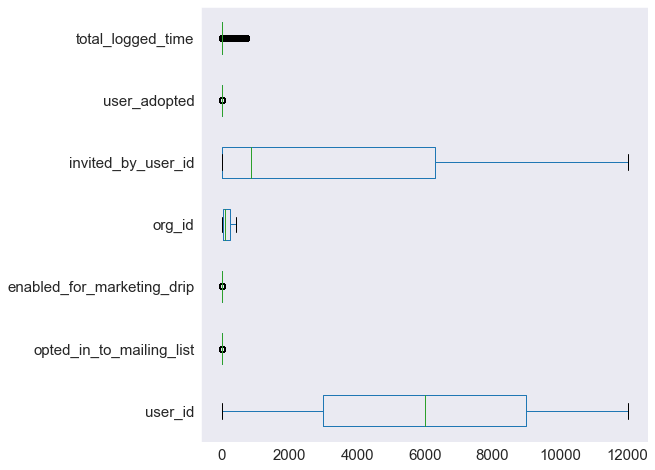

In [24]:
#Checking the outliers
users.boxplot(vert = False,grid = False,fontsize  =15,figsize = (8,8))

array([[<AxesSubplot:title={'center':'enabled_for_marketing_drip'}>,
        <AxesSubplot:title={'center':'invited_by_user_id'}>,
        <AxesSubplot:title={'center':'opted_in_to_mailing_list'}>],
       [<AxesSubplot:title={'center':'org_id'}>,
        <AxesSubplot:title={'center':'total_logged_time'}>,
        <AxesSubplot:title={'center':'user_adopted'}>],
       [<AxesSubplot:title={'center':'user_id'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

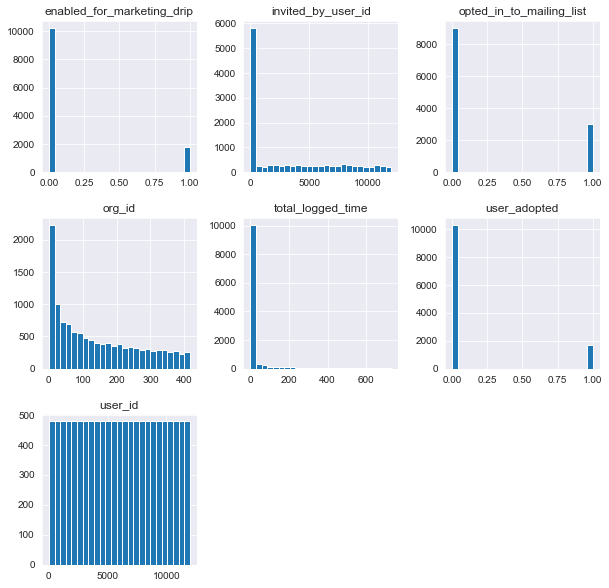

In [25]:
users.hist(bins = 25,figsize=(10,10))

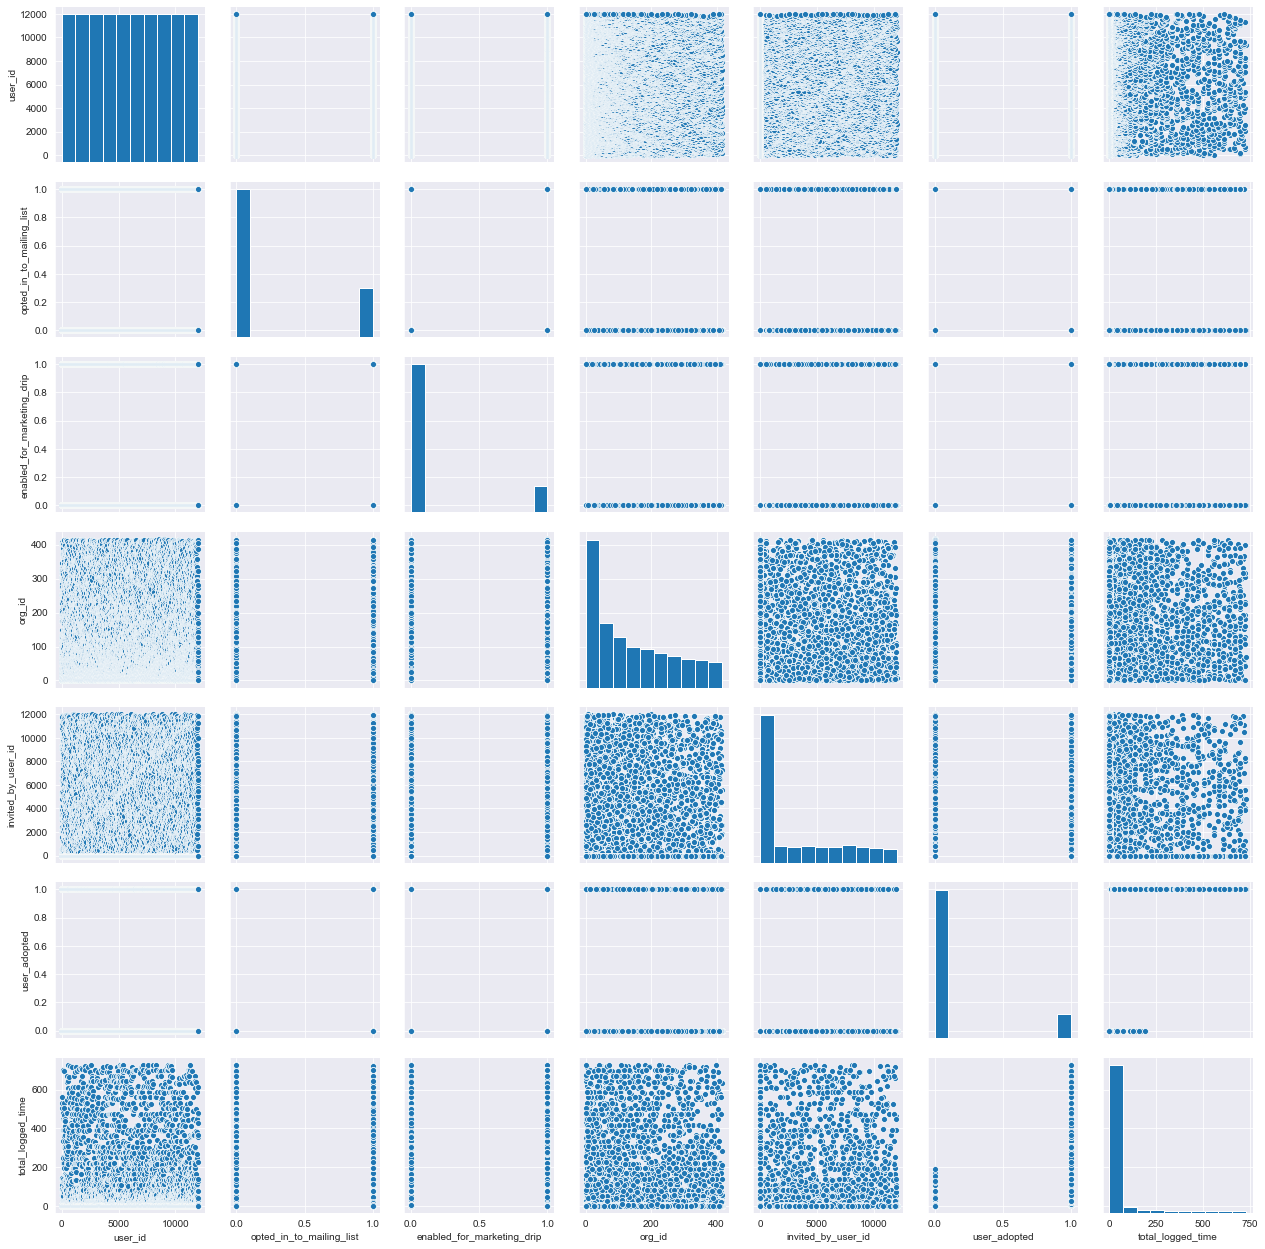

In [26]:
#Explore data relationships
sns.pairplot(users)

<AxesSubplot:>

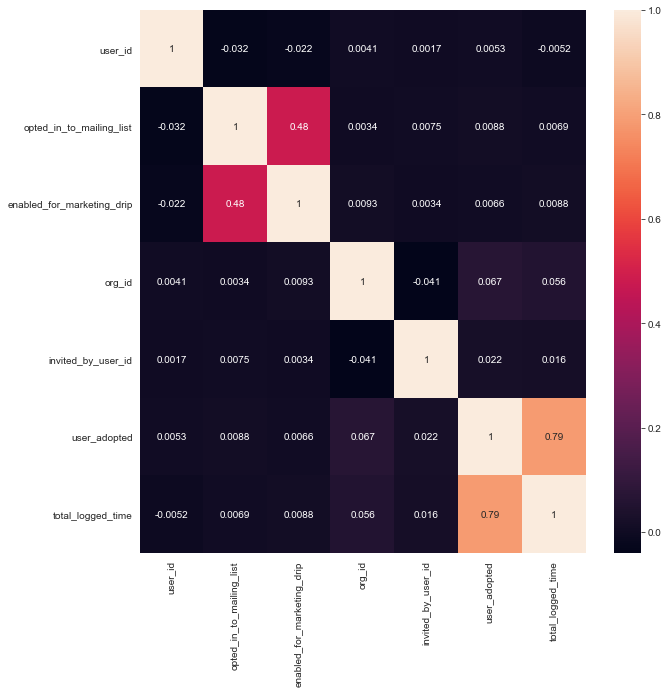

In [27]:
#Heat map - Correlation between features
plt.figure(figsize = (10,10))
sns.heatmap(users.corr(),annot = True)

Summary Findings:

- Users adoption is strongly correlated with the total_logged_time.
- And Users adoption has a very minimal correlation with the other features.

Lets visualize the relation between total_logged_time and user adoption.

In [28]:
users['total_logged_time'].agg({'min','max'})

min      0
max    729
Name: total_logged_time, dtype: int64

<AxesSubplot:title={'center':'Users adoption by total logged time per 100 days'}, xlabel='total_logged_time', ylabel='count'>

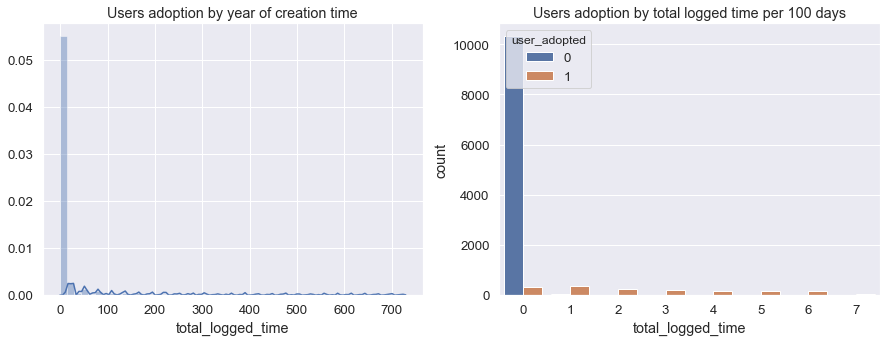

In [29]:
sns.set(font_scale = 1.2)
fig, ax = plt.subplots(1,2,figsize = (15,5))
ax = ax.flatten()

ax[0].set_title("Users adoption by year of creation time")
sns.distplot(users['total_logged_time'],ax = ax[0])

ax[1].set_title("Users adoption by total logged time per 100 days")
sns.countplot(x = users['total_logged_time']//100,hue = users['user_adopted'],ax = ax[1])


Summary Findings:
    
- The non adopted users are having total logged time mostly below 100 days.
- And very small amount of non adopted users are between 100-200 days.
- And finally witnessed that most of the adopted users are having total logged time above 200 days.

Now lets visualize the relation between target variable with other categorical variables.

In [30]:
users.select_dtypes(include = 'object').columns

Index(['name', 'email', 'creation_source', 'domain'], dtype='object')

Text(0.5, 1.0, 'Users adoption')

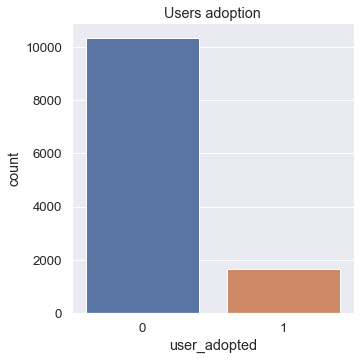

In [31]:
#Distribution of target variable
sns.catplot(x = 'user_adopted',kind = 'count', data = users)
plt.title("Users adoption")

Summary Findings:

- There are more non adopted users than adopted users.
- Since the classes are not represented equally, it can be referenced as **imbalanced data**.

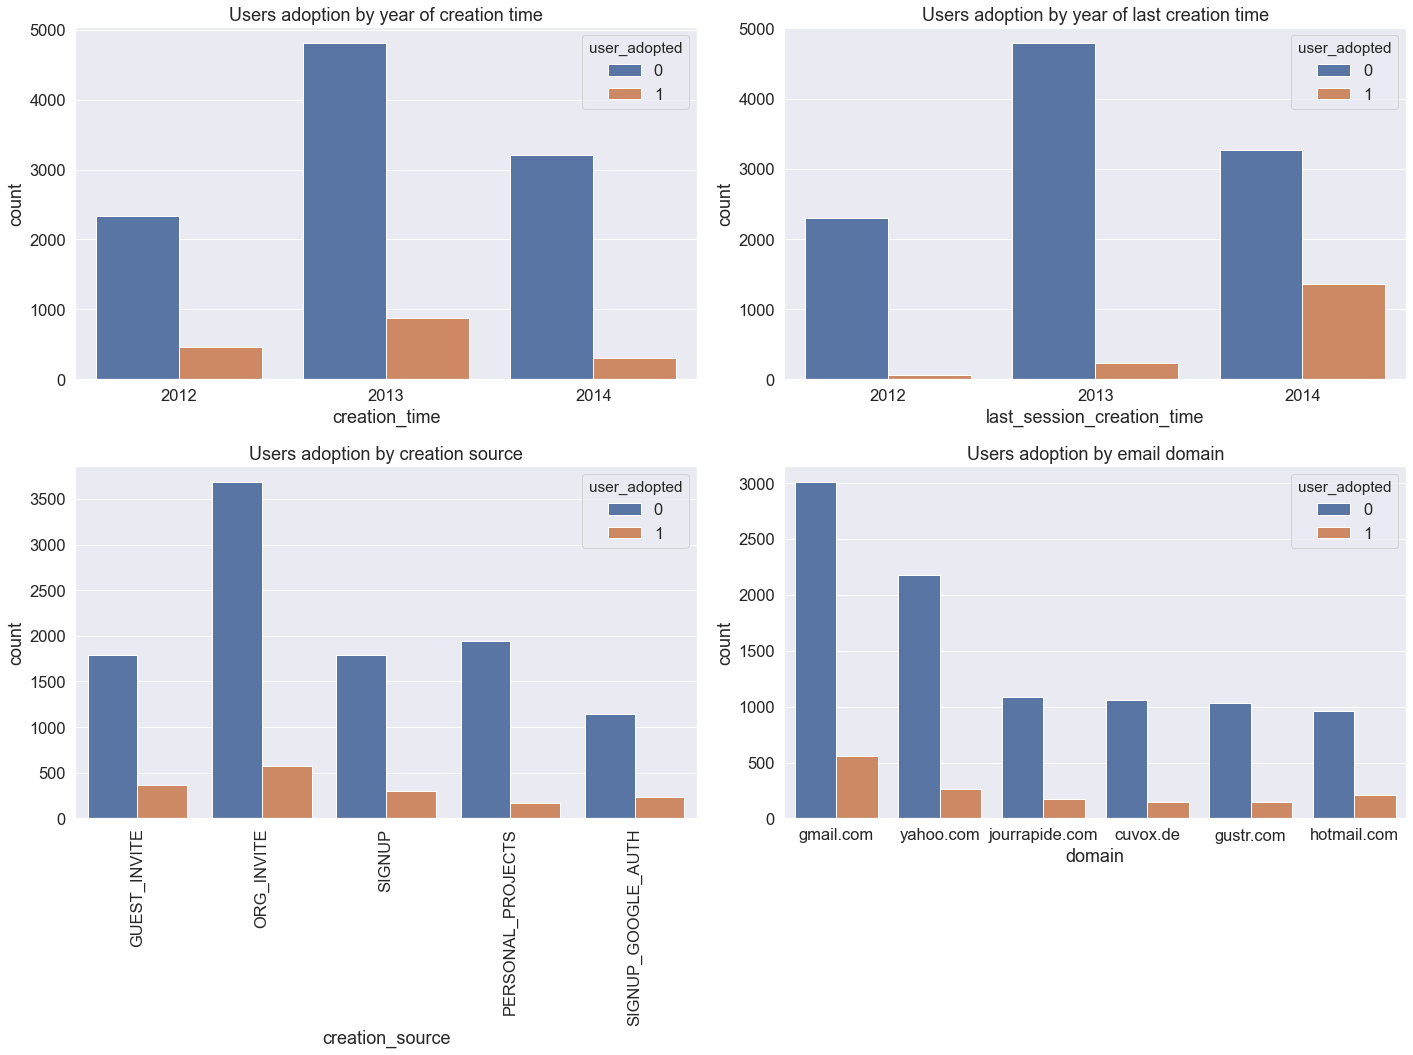

In [32]:
#Visualizing the phone and ultimate_black_user and their relationship with the target varibale.
sns.set(font_scale = 1.5)
fig, ax = plt.subplots(2,2,figsize = (20,15))
ax = ax.flatten()

ax[0].set_title("Users adoption by year of creation time")
sns.countplot(users['creation_time'].dt.year,hue = users['user_adopted'],ax = ax[0])

ax[1].set_title("Users adoption by year of last creation time")
sns.countplot(users['last_session_creation_time'].dt.year,hue = users['user_adopted'],ax = ax[1])

ax[2].set_title("Users adoption by creation source")
sns.countplot(users['creation_source'],hue = users['user_adopted'],ax = ax[2])
xlabels = ax[2].get_xticklabels()
ax[2].set_xticklabels(xlabels, rotation=90)

ax[3].set_title("Users adoption by email domain")
sns.countplot(users['domain'],order = users['domain'].value_counts().iloc[:6].index,
              hue = users['user_adopted'],ax = ax[3])

fig.tight_layout()

Summary Findings:

- 1. Users who created their account in 2013 are adopted more than the rest of the creation years.
- 2. Users who are most recently logged in are adopted more.
- 3. Users whose creation source **ORG_INVITE** are adopted more than rest of the creation sources.
- 4. Users whose email domain as **gmail.com** are adopted more than rest of the email domains.

### Pre Processing

In [33]:
users.columns

Index(['user_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id',
       'user_adopted', 'total_logged_time', 'domain'],
      dtype='object')

In [34]:
from datetime import datetime
users['creation_time'] = users['creation_time'].apply(datetime.toordinal)
users['last_session_creation_time'] = users['last_session_creation_time'].apply(datetime.toordinal)

In [35]:
#delete unnecessary features
users.drop(['name','email'],axis = 1,inplace = True)

In [36]:
users = pd.get_dummies(users ,drop_first = True)

In [38]:
# Split the data
from sklearn.model_selection import train_test_split
X = users.drop(['user_adopted'],axis= 1)
y = users.user_adopted

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)


In [39]:
#Scale the data
from sklearn.preprocessing import StandardScaler
import numpy as np
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = StandardScaler().fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

### Modeling

In [40]:
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix,precision_score, recall_score
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss

>SVM 0.945 (0.003)
For  SVC(gamma='auto', probability=True) :
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      2054
           1       1.00      0.67      0.80       346

    accuracy                           0.95      2400
   macro avg       0.97      0.84      0.89      2400
weighted avg       0.95      0.95      0.95      2400

ROC_AUC:0.9909762988895205


>KNN 0.943 (0.003)
For  KNeighborsClassifier() :
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      2054
           1       0.99      0.60      0.74       346

    accuracy                           0.94      2400
   macro avg       0.96      0.80      0.86      2400
weighted avg       0.94      0.94      0.93      2400

ROC_AUC:0.8769720438338277


>RF 0.974 (0.004)
For  RandomForestClassifier(n_estimators=500, warm_start=True) :
               precision    recall  f1-score   support

           0       0.97      0.99   

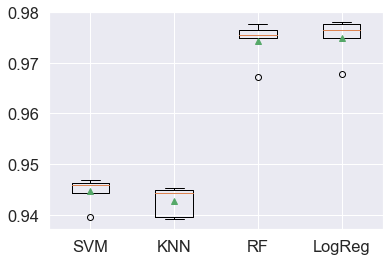

Choosing the best model:
                      SVM       KNN        RF    LogReg
train_accuracy  0.960938  0.954479         1  0.978333
test_accuracy   0.952083  0.940833  0.967917  0.967083
precision       0.995708  0.985714  0.926984  0.921136
recall           0.67052  0.598266  0.843931  0.843931
F1              0.801382  0.744604   0.88351  0.880845
AUC             0.990976  0.876972  0.985914  0.989224
CPU times: user 7min 52s, sys: 5.86 s, total: 7min 58s
Wall time: 13min 40s


In [41]:
%%time
# define models to test
def get_models():
    models, names = list(), list()
    
    # SVM
    models.append(SVC(gamma='auto',probability=True))
    names.append('SVM')
    
    # KNN
    models.append(KNeighborsClassifier())
    names.append('KNN')
    
    # RF
    models.append(RandomForestClassifier(n_estimators=500,warm_start=True))
    names.append('RF')
    
    # ET
    #models.append(ExtraTreesClassifier(n_estimators=500))
    #names.append('ET')
    
    #LogisticRegression
    models.append(LogisticRegression())
    names.append('LogReg')
    
    #XGB
    #models.append(xgb.XGBClassifier())
    #names.append('XGB')
    return models, names

# define models
models, names = get_models()
results = list()

# Create Datframe to compare models
metrics = pd.DataFrame(index=['train_accuracy','test_accuracy', 'precision', 'recall','F1', 'AUC'], 
                       columns=names)


# evaluate each model
for i in range(len(models)):
    
    classifier = models[i].fit(X_train,y_train)
    
    # evaluate the model and store results
    cv = StratifiedKFold(n_splits = 5, shuffle=False, random_state = 1)
    scores = cross_val_score(models[i], X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    results.append(scores)
    
    y_pred = classifier.predict(X_test)
    y_pred_proba = classifier.predict_proba(X_test)[::,1]
    
    metrics.loc['train_accuracy',names[i]] = classifier.score(X_train,y_train)
    metrics.loc['test_accuracy',names[i]] =  accuracy_score(y_test,y_pred)  
    metrics.loc['precision',names[i]] = precision_score(y_test,y_pred)
    metrics.loc['recall',names[i]] = recall_score(y_test,y_pred)
    metrics.loc['F1',names[i]] = f1_score(y_test,y_pred)
    metrics.loc['AUC',names[i]] = roc_auc_score(y_test,y_pred_proba)
    
    print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))
    print("For ",models[i],":\n" ,classification_report(y_test,y_pred))
    print(f"ROC_AUC:{roc_auc_score(y_test,y_pred_proba)}\n\n")
    
    
# plot the results
plt.boxplot(results, labels=names, showmeans=True)
plt.show()
print("Choosing the best model:\n",metrics)


### Choosing the best model

In [47]:
metrics

,SVM,KNN,RF,LogReg
train_accuracy,0.960938,0.954479,1,0.978333
test_accuracy,0.952083,0.940833,0.967917,0.967083
precision,0.995708,0.985714,0.926984,0.921136
recall,0.67052,0.598266,0.843931,0.843931
F1,0.801382,0.744604,0.88351,0.880845
AUC,0.990976,0.876972,0.985914,0.989224


From the above table, we can clearly say that Random Forest outperformed all other models.

### Comparing the models

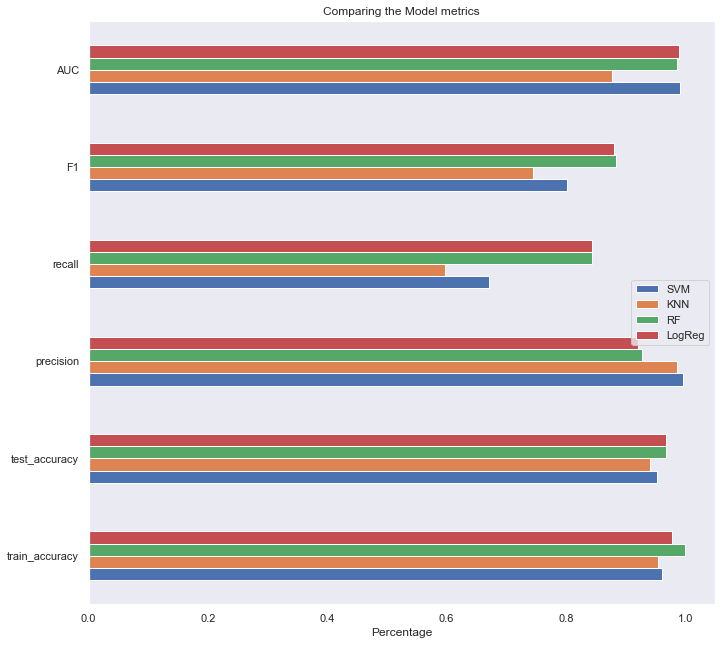

In [124]:
fig, ax = plt.subplots(figsize=(10,10))
metrics.plot(kind='barh', ax=ax)
ax.set_xlabel('Percentage')
ax.set_title('Comparing the Model metrics')
ax.grid()


### Optimizing RandomForest through Hyper Parameter Tuning

In [49]:
#Randomised cross validation
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, classification_report, recall_score, precision_recall_curve

# Compute the costs
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
weights = dict(zip(np.unique(y_train),class_weight))

#RandomForestClassifier with weights(COST-SENSITIVE METHOD)


cross_val = StratifiedKFold(n_splits=5,shuffle=True, random_state = 1)
#index_iterator = cross_val.split(X_train, y_train)
params = {'max_depth': [20,25,30], 
          'min_samples_split': [4,6,8],
          'min_samples_leaf' : [2,4,8],
          'n_estimators' : [400,600,800],
          'max_features':[0.5,0.7,'sqrt','auto']
             }
scoring = {'Recall': make_scorer(recall_score,average = 'weighted'),
           'f1_score': make_scorer(f1_score,average = 'weighted'),
           'precision': make_scorer(precision_score,average = 'weighted'),
           'Accuracy': make_scorer(accuracy_score)
          }
clf = RandomForestClassifier()
clf_random = RandomizedSearchCV(estimator = clf, param_distributions = params, n_iter =10, cv = cross_val,
                            verbose=2, random_state =1, n_jobs = -1,scoring=scoring,refit='Accuracy')
clf_random.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 15.6min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [20, 25, 30],
                                        'max_features': [0.5, 0.7, 'sqrt',
                                                         'auto'],
                                        'min_samples_leaf': [2, 4, 8],
                                        'min_samples_split': [4, 6, 8],
                                        'n_estimators': [400, 600, 800]},
                   random_state=1, refit='Accuracy',
                   scoring={'Accuracy': make_scorer(accuracy_score),
                            'Recall': make_scorer(recall_score, average=weighted),
                            'f1_score': make_scorer(f1_score, average=weighted),
                            'precision': make_scorer(precision_score, average=weighted)},
                   verbose=2)

In [50]:
clf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 8,
 'min_samples_leaf': 4,
 'max_features': 0.5,
 'max_depth': 30}

### Final Model

In [52]:
# Compute the costs
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
weights = dict(zip(np.unique(y_train),class_weight))

#RandomForestClassifier with weights(COST-SENSITIVE METHOD)

from sklearn.ensemble import RandomForestClassifier
model_weights = RandomForestClassifier(n_estimators=600,class_weight = weights,random_state = 1,n_jobs=-1,
                                      min_samples_split = 8,min_samples_leaf = 4,max_features = 0.5,
                                       max_depth = 30)
rf_weight = model_weights.fit(X_train, y_train)

cv = StratifiedKFold(n_splits = 5, shuffle=False, random_state = 1)

# evaluate model
scores = cross_val_score(model_weights, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

y_pred = rf_weight.predict(X_test)
pred_prob = rf_weight.predict_proba(X_test)
ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)
print("train accuracy: ",model_weights.score(X_train,y_train))
print("test accuracy: ", model_weights.score(X_test,y_test))
print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

train accuracy:  0.9880208333333333
test accuracy:  0.9633333333333334
Random Forest: Accuracy=0.963
Random Forest: f1-score=0.964
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2054
           1       0.86      0.89      0.88       346

    accuracy                           0.96      2400
   macro avg       0.92      0.93      0.93      2400
weighted avg       0.96      0.96      0.96      2400

[[2003   51]
 [  37  309]]


### Confusion matrix and ROC Curve

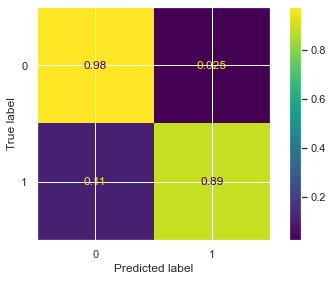

<Figure size 576x576 with 0 Axes>

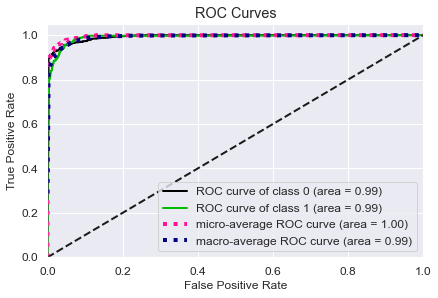

In [156]:
# Plot Confsion Matrix and ROC Curve
import scikitplot as skplt
plot_confusion_matrix(rf_weight, X_test, y_test,normalize='true')
plt.figure(figsize=(8,8))
skplt.metrics.plot_roc(y_test, rf_weight.predict_proba(X_test))
plt.show()

### Randomforest feature Importance

In [81]:
# Get numerical feature importances
importances = list(rf_weight.feature_importances_)
feature_list = list(X.columns)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {} Importance: {}'.format(*pair)) for pair in feature_importances[:10]]

Variable: total_logged_time Importance: 0.75
Variable: last_session_creation_time Importance: 0.17
Variable: creation_time Importance: 0.03
Variable: user_id Importance: 0.01
Variable: org_id Importance: 0.01
Variable: invited_by_user_id Importance: 0.01
Variable: opted_in_to_mailing_list Importance: 0.0
Variable: enabled_for_marketing_drip Importance: 0.0
Variable: creation_source_ORG_INVITE Importance: 0.0
Variable: creation_source_PERSONAL_PROJECTS Importance: 0.0


[None, None, None, None, None, None, None, None, None, None]

1195


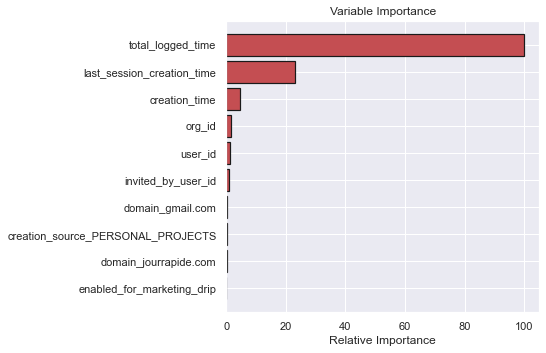

In [113]:
plt.rcParams['font.size'] = 10
plt.style.use('fivethirtyeight')
sns.set(font_scale = 1)
feature_importance = rf_weight.feature_importances_
feature_importance = feature_importance
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(5,5))
plt.barh(pos[-10:], feature_importance[sorted_idx][-10:], 
         align='center',color = 'r', edgecolor = 'k',linewidth = 1.2)
plt.yticks(pos[-10:], X.columns[sorted_idx][-10:])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Summary findings:
    
- unsurprisingly, as expected **total_logged_time** with 75% importance is the primary variable for predicting user adoption followed by last_session_creation_time,creation_time.

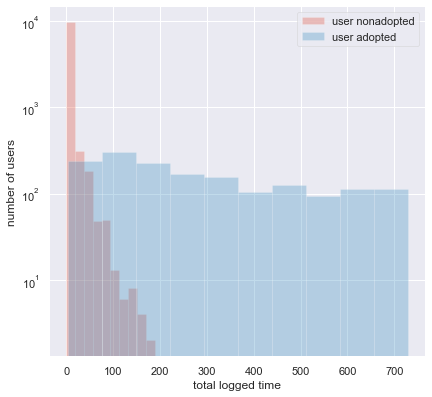

In [178]:
# Total logged time distribution between adopted users and non-adopted users
sns.set_style('darkgrid')
plt.figure(figsize=(6,6))
plt.hist(users[users['user_adopted'] == 0].total_logged_time,label='user nonadopted',alpha=0.3)
plt.hist(users[users['user_adopted'] == 1].total_logged_time,label='user adopted',alpha=0.3)
plt.legend(loc='best')
plt.yscale('log')
plt.xlabel('total logged time')
plt.ylabel('number of users')
plt.show()


### Conclusion

We tried 4 models, out of which RandomForest gave us the best results for predicting user's adoption with more than 96% accuracy. The most important features is total logged time of the user(time which is in between creation time and last session creation between). This is a strong indication that the users who spend more time in their account are going to be adopted users in the future. So I recommend the organizations to take necessary actions to attract users to spend more time in their account by introducing promotions, offers or related ads.